# 41: Building a CNN for MNIST

## 🎯 Objective
Can a computer learn to read handwriting? In this notebook, we combine all the concepts we've learned—convolutions, pooling, and linear layers—to build a complete Convolutional Neural Network (CNN). We will train this model on the classic MNIST dataset to recognize handwritten digits, moving from raw pixel data to high-accuracy predictions.

## 📚 Key Concepts
* **Data Preprocessing:** Reshaping flat vectors into 4D image tensors (Batch, Channel, Height, Width) required for CNNs.
* **Model Architecture:** Stacking `Conv2d` layers for feature extraction followed by `Linear` layers for classification.
* **Flattening:** The critical step of converting 2D feature maps into a 1D vector before the final classification layers.
* **Training Loop:** The standard process of forward pass, loss calculation, backpropagation, and weight updates.

## 1. Import Libraries

We import the necessary PyTorch modules. We also use `sklearn` for splitting our data and `matplotlib` for visualization.

In [1]:
## Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary
import matplotlib.pyplot as plt

## 2. Data Preparation

The MNIST dataset typically comes as a list of flat vectors (784 pixels). However, CNNs expect 2D images. 

### Important Steps:
1.  **Normalization:** We scale pixel values to the range [0, 1] to ensure numerical stability.
2.  **Reshaping:** We must reshape the data from `(N, 784)` to `(N, 1, 28, 28)`. The '1' represents the single grayscale color channel.

In [2]:
### Import and Process the data

# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Reshape to (Batch, Channel, Height, Width)
dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)

In [3]:
dataNorm.shape

(20000, 1, 28, 28)

## 3. Creating Datasets and DataLoaders

We follow the standard PyTorch workflow:
1.  Convert numpy arrays to PyTorch Tensors.
2.  Split the data into training and testing sets.
3.  Wrap them in `TensorDataset`.
4.  Create `DataLoader` objects to handle batching and shuffling.

In [4]:
### Creating train/test split 

# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [5]:
# check size (should be Batch x Channel x Height x Width)
train_loader.dataset.tensors[0].shape

torch.Size([18000, 1, 28, 28])

## 4. Defining the Model Architecture

We define a class `mnistNet` that inherits from `nn.Module`. 

### Architecture Breakdown
* **Conv1:** Takes 1 channel, outputs 10 feature maps. Kernel size 5.
* **Conv2:** Takes 10 channels, outputs 20 feature maps. Kernel size 5.
* **Flatten:** Unrolls the 3D feature maps (20 x 5 x 5) into a 1D vector (500 units).
* **Linear Layers:** A standard feed-forward network to map features to the 10 digit classes.

**Note:** We calculate `outSize = 20*5*5` manually based on how the image dimensions shrink after convolutions and pooling. 

In [6]:
### Create the DL Model

def createTheMNISTNet(printToggle = False):
    
    class mnistNet(nn.Module):
        def __init__(self, printToggle):
            super().__init__()
            
            # Convolutional layers
            self.conv1 = nn.Conv2d(in_channels= 1, out_channels= 10, kernel_size= 5, padding= 1, stride= 1)
            self.conv2 = nn.Conv2d(in_channels= 10, out_channels= 20, kernel_size= 5, padding= 1, stride= 1)
            
            # Flatten layer to transition from Conv to Linear
            self.flatten = nn.Flatten()
            
            # Linear layers (fully connected)
            outSize = 20*5*5
            self.fc1 = nn.Linear(outSize, 50)
            self.out = nn.Linear(50, 10)
            self.print = printToggle
            
        def forward(self, x):
            # Convolution -> MaxPool -> ReLU
            print(f"Input: {x.shape}") if self.print else None
            
            # Block 1
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            print(f"Layer conv1/pool1: {x.shape}") if self.print else None
            
            # Block 2
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            print(f"Layer conv2/pool2: {x.shape}") if self.print else None
            
            # Vectorize
            x = self.flatten(x)
            print(f"Vectorized: {x.shape}") if self.print else None
            
            # Linear layers
            x = F.relu(self.fc1(x))
            x = self.out(x)
            return x
            
    # Create the net
    net = mnistNet(printToggle)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, lossfun, optimizer

### Testing the Model Dimensions
Before training, it is smart to run a single batch through the untrained model. This verifies that our layer shapes match up and prevents runtime errors during the training loop.

In [7]:
# test the model with one batch of data
net, lossfun, optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nOutput shape:')
print(yHat.shape)
print(y.shape)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorized: torch.Size([32, 500])

Output shape:
torch.Size([32, 10])
torch.Size([32])


In [8]:
# Using torchsummary to see the parameter count
summary(net, (1, 28, 28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorized: torch.Size([2, 500])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
           Flatten-3                  [-1, 500]               0
            Linear-4                   [-1, 50]          25,050
            Linear-5                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


## 5. Training the Model

We define the training function. This is standard PyTorch:
1.  **Epoch Loop:** Iterate through the dataset multiple times.
2.  **Batch Loop:** Iterate through the DataLoader.
3.  **Forward Pass:** Compute predictions (`net(X)`).
4.  **Loss:** Calculate error (`lossfun`).
5.  **Backward Pass:** Calculate gradients (`loss.backward()`).
6.  **Update:** Update weights (`optimizer.step()`).
7.  **Evaluation:** Check accuracy on the test set at the end of every epoch.

In [9]:
### Create a function to train the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.inference_mode(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

## 6. Execution and Visualization

Finally, we train the network and plot the results. We expect to see the loss decrease and the accuracy increase (likely exceeding 95%).

In [10]:
### Run the model and plot the results!
trainAcc,testAcc,losses,net = function2trainTheModel()

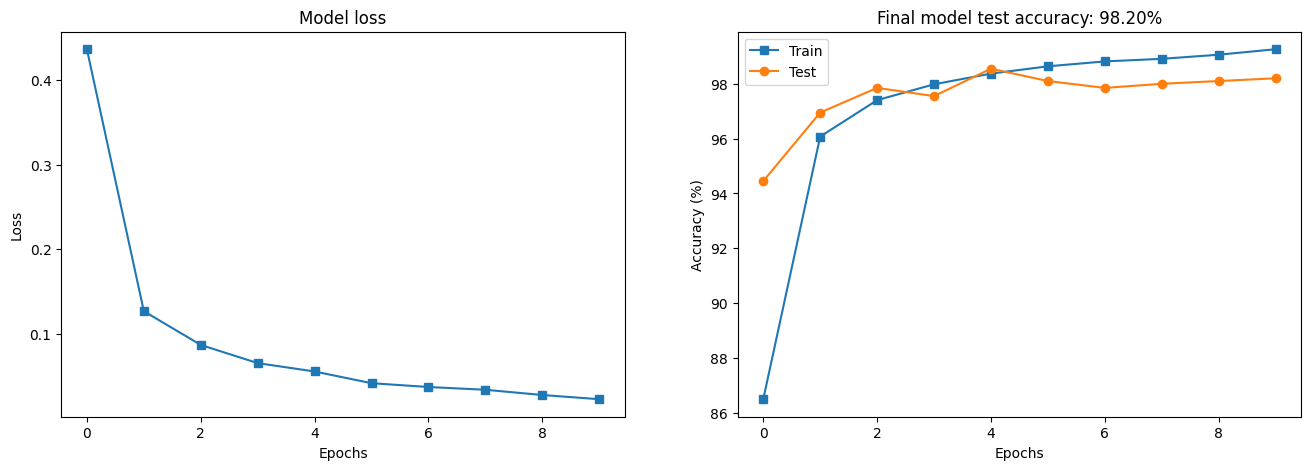

In [11]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()